In [1]:
import numpy as np
import torch
import pandas as pd
import csv
from collections import defaultdict
import ast
from datetime import datetime
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from os.path import exists
from os import makedirs
import torch.nn.functional as F
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import collections

In [2]:
zip_dictionary = {'San Francisco': 94107,
                 'Redwood City': 94063,
                 'Palo Alto': 94301,
                 'Mountain View': 94041,
                 'San Jose': 95113}

In [3]:
"""read station_data.csv file

returns
    station_dictionary {id: [lat, long, dock count]}
    station_zip_dictionary {id: zip}
"""
station_dictionary = defaultdict(list)
station_zip_dictionary = {}
with open('./bikes_data/data/station_data.csv', 'r') as station_data:
  station_data.readline()
  reader = csv.reader(station_data, delimiter=',', quotechar='|')
  for row in reader:
    for i in range(2, 5):
      station_dictionary[int(row[0])].append(ast.literal_eval(row[i]))
    station_zip_dictionary[int(row[0])] = zip_dictionary[row[5]]

station_dictionary = collections.OrderedDict(sorted(station_dictionary.items()))
print("Number of station is:", len(station_dictionary))
print("Example for station 2:", station_dictionary[2], station_zip_dictionary[2])

Number of station is: 76
Example for station 2: [37.329732, -121.901782, 27] 95113


In [4]:
"""read weather_data.csv file

returns
    weather_dictionary {(date, zip): [Max Temperature, Mean Temperature, ...]}
"""
events_dictionary = {'': 0, 'Rain': -1, 'Fog-Rain': -2, 'Rain-Thunderstorm': -3, 'Fog': -4}
weather_dictionary = defaultdict(list)
with open('./bikes_data/data/weather_data.csv', 'r') as weather_data:
  weather_data.readline()
  reader = csv.reader(weather_data, delimiter=',', quotechar='|')
  for row in reader:
    for i in range(1, 23):
      if row[i] in events_dictionary:
        weather_dictionary[(row[0], int(row[23]))].append(events_dictionary[row[i]])
      else:
        weather_dictionary[(row[0], int(row[23]))].append(ast.literal_eval(row[i]))

print("Example for (01/09/2014, 95113):", weather_dictionary[('01/09/2014', 95113)])

Example for (01/09/2014, 95113): [86, 72, 58, 60, 54, 50, 86, 59, 31, 29.86, 29.81, 29.75, 10, 10, 10, 17, 5, 22, 0, 0, 0, 296]


In [5]:
"""read trip_data.csv file

returns
    trip_started_dictionary {(date, station id, hour): count}
    trip_ended_dictionary {(date, station id, hour): count}
    net_rate_dictionary {(date, station id, hour): net rate}
"""
trip_started_dictionary = {}
trip_ended_dictionary = {}
net_rate_dictionary = {}
date_list = []
with open('./bikes_data/data/trip_data.csv', 'r') as trip_data:
  trip_data.readline()
  reader = csv.reader(trip_data, delimiter=',', quotechar='|')
  for row in reader:
    date_list.append(row[1].split(' ')[0])
    if (row[1].split(' ')[0], int(row[2]), int(row[1].split(' ')[1].split(':')[0])) in trip_started_dictionary:
      trip_started_dictionary[(row[1].split(' ')[0], int(row[2]), int(row[1].split(' ')[1].split(':')[0]))] += 1
    else:
      trip_started_dictionary[(row[1].split(' ')[0], int(row[2]), int(row[1].split(' ')[1].split(':')[0]))] = 0
     
    if (row[1].split(' ')[0], int(row[2]), int(row[1].split(' ')[1].split(':')[0])) not in trip_ended_dictionary:
      trip_ended_dictionary[(row[1].split(' ')[0], int(row[2]), int(row[1].split(' ')[1].split(':')[0]))] = 0
      
    if (row[3].split(' ')[0], int(row[4]), int(row[3].split(' ')[1].split(':')[0])) in trip_ended_dictionary:
      trip_ended_dictionary[(row[3].split(' ')[0], int(row[4]), int(row[3].split(' ')[1].split(':')[0]))] += 1
    else:
      trip_ended_dictionary[(row[3].split(' ')[0], int(row[4]), int(row[3].split(' ')[1].split(':')[0]))] = 0
  
    if (row[3].split(' ')[0], row[4], int(row[3].split(' ')[1].split(':')[0])) not in trip_started_dictionary:
      trip_started_dictionary[(row[3].split(' ')[0], int(row[4]), int(row[3].split(' ')[1].split(':')[0]))] = 0
      
for key in trip_ended_dictionary:
  net_rate_dictionary[key] = trip_ended_dictionary[key] - trip_started_dictionary[key]
  
print("Example of net rate dictionary:", dict(list(net_rate_dictionary.items())[0:20]))

Example of net rate dictionary: {('31/08/2015', 50, 23): 0, ('31/08/2015', 70, 23): 1, ('31/08/2015', 31, 23): 0, ('31/08/2015', 27, 23): 0, ('31/08/2015', 47, 23): 0, ('31/08/2015', 64, 23): 0, ('31/08/2015', 10, 23): 0, ('31/08/2015', 8, 23): 0, ('31/08/2015', 51, 23): -1, ('31/08/2015', 60, 23): 1, ('31/08/2015', 68, 23): 0, ('31/08/2015', 60, 22): 0, ('31/08/2015', 74, 22): 0, ('31/08/2015', 56, 22): 0, ('31/08/2015', 55, 22): 0, ('31/08/2015', 47, 21): 0, ('31/08/2015', 66, 22): 0, ('31/08/2015', 60, 21): 0, ('31/08/2015', 77, 22): 0, ('31/08/2015', 67, 21): 0}


In [6]:
"""Generate samples and labels"""
dates = list(set([datetime.strptime(ts, "%d/%m/%Y") for ts in date_list]))
dates.sort()
sorteddates = [datetime.strftime(ts, "%d/%m/%Y") for ts in dates]

samples = []
labels = []

for date in sorteddates:
  for time in range(7, 16):
    try:
      data_tmp = []
      for i in range(time, time + 3):
        matrix_features = []
        for station in station_dictionary.keys():
          if (date, station, i) not in net_rate_dictionary:
            trip_started_dictionary[(date, station, i)] = 0
            trip_ended_dictionary[(date, station, i)] = 0
            net_rate_dictionary[(date, station, i)] = 0
            
          matrix_features.append(station_dictionary[station] + 
                                [trip_started_dictionary[(date, station, i)]] +
                                [trip_ended_dictionary[(date, station, i)]] +
                                [net_rate_dictionary[(date, station, i)]] +
                                weather_dictionary[(date, station_zip_dictionary[station])])
        data_tmp.append(matrix_features)

      label_tmp = []
      for station in station_dictionary.keys():
        label_tmp.append(net_rate_dictionary[(date, station, time + 2)])

      labels.append(label_tmp)
      samples.append(data_tmp)
    except KeyError:
      continue
      
samples = np.array(samples)
labels = np.array(labels)
print("Length of total data is:", len(samples))

Length of total data is: 3285


Epoch: 0 Training RMSE: 1.9919546364071867 Validation RMSE: 2.1622747719718016
Epoch: 1 Training RMSE: 1.9860143199781026 Validation RMSE: 2.1668802238857285
Epoch: 2 Training RMSE: 1.9763405853036342 Validation RMSE: 2.165387879382698
Epoch: 3 Training RMSE: 1.9833102604075086 Validation RMSE: 2.154878002721649
Epoch: 4 Training RMSE: 1.977406944722332 Validation RMSE: 2.166464405572656
Epoch: 5 Training RMSE: 1.976396023980252 Validation RMSE: 2.164469838811253
Epoch: 6 Training RMSE: 1.977518844392532 Validation RMSE: 2.162302040990676
Epoch: 7 Training RMSE: 1.9720294687922661 Validation RMSE: 2.1556344379956225
Epoch: 8 Training RMSE: 1.9630022882165414 Validation RMSE: 2.147302142117514
Epoch: 9 Training RMSE: 1.9022101902707287 Validation RMSE: 2.030685139457768
Epoch: 10 Training RMSE: 1.7481934723180512 Validation RMSE: 1.866161580363842
Epoch: 11 Training RMSE: 1.6248917139834724 Validation RMSE: 1.7897408888462303
Epoch: 12 Training RMSE: 1.569810900986989 Validation RMSE: 1

Epoch: 104 Training RMSE: 1.18206055969973 Validation RMSE: 1.3804742699836345
Epoch: 105 Training RMSE: 1.183280599004943 Validation RMSE: 1.3862975836174505
Epoch: 106 Training RMSE: 1.180412348716062 Validation RMSE: 1.3862559918342896
Epoch: 107 Training RMSE: 1.1805759828502103 Validation RMSE: 1.3950111714620612
Epoch: 108 Training RMSE: 1.1784556667559856 Validation RMSE: 1.4398088785501477
Epoch: 109 Training RMSE: 1.1778124660955318 Validation RMSE: 1.3659254775748524
Epoch: 110 Training RMSE: 1.1763889148984072 Validation RMSE: 1.3791153075311016
Epoch: 111 Training RMSE: 1.1761411757982196 Validation RMSE: 1.3752370643778464
Epoch: 112 Training RMSE: 1.1738540837101423 Validation RMSE: 1.3802839794746147
Epoch: 113 Training RMSE: 1.1742216982073346 Validation RMSE: 1.367688480145891
Epoch: 114 Training RMSE: 1.1731194050103417 Validation RMSE: 1.3726157846043383
Epoch: 115 Training RMSE: 1.1723961401552485 Validation RMSE: 1.3619060491329398
Epoch: 116 Training RMSE: 1.16991

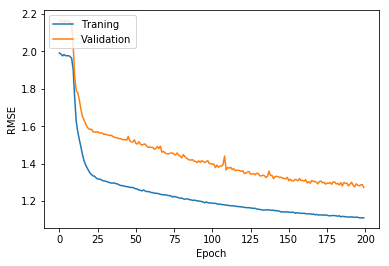

In [7]:
"""Build and train model
input: B x 3 x 76 x 28 features
output: B x 76 net rates
where 76 is the number of stations,
B is the batch size,
3 is 3 hours in a row,
28 is the number of features for each station at a given hour
"""
N_EPOCH = 200
BATCH_SIZE = 64
NUM_OUTPUTS = 76
LEARNING_RATE = 0.01

class DriveData(data.Dataset):
  def __init__(self, samples, labels, transform=None):
    self.transform = transform
    self.__xs = samples
    self.__ys = labels

  def __getitem__(self, index):
    return (self.__xs[index], self.__ys[index])

  def __len__(self):
    return len(self.__xs)
  
class ConvNet(nn.Module):
  def __init__(self, num_outputs=76):
    super(ConvNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 9, kernel_size=5, stride=1),
      nn.BatchNorm2d(9),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(9, 16, kernel_size=3, stride=1),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(16, 16, kernel_size=3, stride=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc = nn.Sequential(
      nn.Linear(112, 128),
      nn.Sigmoid(),
      nn.Linear(128, num_outputs))

  def forward(self, x):
    out = self.features(x)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out
  
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_list = []
valid_list = []
model = ConvNet().to(device)
model = model.double()
criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
train_dataset = DriveData(samples[0: 2600], labels[0: 2600])
valid_dataset = DriveData(samples[2600: 3285], labels[2600: 3285])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)
for epoch in range(N_EPOCH):
  correct = 0
  count = 0
  loss_total = 0
  for i, (seqs, labels) in enumerate(train_loader):
    seqs = seqs.to(device)
    labels = labels.to(device)
    outputs = model(seqs)
    count += 1
    loss = torch.sqrt(criterion(outputs, torch.autograd.Variable(labels.double())))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_total += loss.item()
  loss_list.append(loss_total/count)
  model.eval()
  with torch.no_grad():
    predictions = []
    Y_valid = []
    for seqs, labels in valid_loader:
      seqs = seqs.to(device)
      labels = labels.to(device)
      outputs = model(seqs)
      predictions.extend(outputs.data.numpy())
      Y_valid.extend(labels.data.numpy())
    valid_list.append(sqrt(mean_squared_error(Y_valid, predictions)))
    print("Epoch:", epoch, "Training RMSE:", loss_total/count, "Validation RMSE:", sqrt(mean_squared_error(Y_valid, predictions)))

_, ax = plt.subplots()
ax.plot(loss_list)
ax.plot(valid_list)
plt.legend(['Traning', 'Validation'], loc='upper left')
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
plt.show()

In [8]:
"""Validate model"""
# Validate the model
model.eval()
with torch.no_grad():
  predictions = []
  Y_valid = []
  for seqs, labels in valid_loader:
    seqs = seqs.to(device)
    labels = labels.to(device)
    outputs = model(seqs)
    predictions.extend(outputs.data.numpy())
    Y_valid.extend(labels.data.numpy())
  
  print("Each row are 76 net rate of 76 station. We have 3285 - 2600 = 685 rows in the validation set.")
  print(np.ceil(outputs.data.numpy()))

Each row are 76 net rate of 76 station. We have 3285 - 2600 = 685 rows in the validation set.
[[ -1.  -0.   1. ...,   8.   1.   1.]
 [  1.  -0.  -0. ...,   2.   1.   1.]
 [  1.   1.  -0. ...,   1.  -0.   1.]
 ..., 
 [  1.   1.   1. ...,   1.   1.   1.]
 [  5.   1.  -0. ...,  11.   3.   1.]
 [  4.  -0.  -0. ...,  21.   5.   1.]]
